In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from blue_conduit_spatial.evaluation import *
import matplotlib.pyplot as plt
from matplotlib import cm



from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import precision_score, recall_score, roc_auc_score

import xgboost

In [2]:
# Shape files truncate column names.  This dictionary is used to restore the whole names.

col_name_dictionary = {'pid': 'pid', 'Property Z': 'Property Zip Code', 'Owner Type': 'Owner Type',
                       'Owner Stat': 'Owner State', 'Homestead': 'Homestead', 'Homestea_1': 'Homestead Percent',
                       'HomeSEV': 'HomeSEV', 'Land Value': 'Land Value', 'Land Impro': 'Land Improvements Value',
                       'Residentia': 'Residential Building Value', 'Resident_1': 'Residential Building Style',
                       'Commercial': 'Commercial Building Value', 'Building S': 'Building Storeys',
                       'Parcel Acr': 'Parcel Acres', 'Rental': 'Rental', 'Use Type': 'Use Type',
                       'Prop Class': 'Prop Class', 'Old Prop c': 'Old Prop class', 'Year Built': 'Year Built',
                       'USPS Vacan': 'USPS Vacancy', 'Zoning': 'Zoning', 'Future Lan': 'Future Landuse',
                       'DRAFT Zone': 'DRAFT Zone', 'Housing Co': 'Housing Condition 2012',
                       'Housing _1': 'Housing Condition 2014', 'Commerci_1': 'Commercial Condition 2013',
                       'Latitude': 'Latitude', 'Longitude': 'Longitude', 'Hydrant Ty': 'Hydrant Type',
                       'Ward': 'Ward', 'PRECINCT': 'PRECINCT', 'CENTRACT': 'CENTRACT', 'CENBLOCK': 'CENBLOCK',
                       'SL_Type': 'SL_Type', 'SL_Type2': 'SL_Type2', 'SL_Lead': 'SL_Lead', 'Ed_July': 'Ed_July',
                       'Ed_March': 'Ed_March', 'Last_Test': 'Last_Test', 'Max_Lead': 'Max_Lead',
                       'Med_Lead': 'Med_Lead', 'Num_Tests': 'Num_Tests', 'Res_Test': 'Res_Test',
                       'Sen_Test': 'Sen_Test', 'SL_private': 'SL_private_inspection',
                       'B_median_a': 'B_median_age_all_women', 'B_median_1': 'B_median_age_all_men', 
                       'B_median_2': 'B_median_age_all', 'B_median_3': 'B_median_age_all_women_white',
                       'B_median_4': 'B_median_age_all_men_white', 'B_median_5': 'B_median_age_all_white',
                       'B_median_6': 'B_median_age_all_women_black', 'B_median_7': 'B_median_age_all_men_black',
                       'B_median_8': 'B_median_age_all_black', 'B_total_bl': 'B_total_black_pop',
                       'B_total_wh': 'B_total_white_pop', 'B_married_': 'B_married_couples',
                       'B_single_w': 'B_single_women', 'B_marrie_1': 'B_married_couples_white',
                       'B_single_1': 'B_single_women_white', 'B_marrie_2': 'B_married_couples_black',
                       'B_single_2': 'B_single_women_black', 'B_marrie_3': 'B_married_couples_w_children',
                       'B_single_m': 'B_single_mothers_w_children', 'B_househol': 'B_households_w_elderly',
                       'B_househod': 'B_househod_no_elderly', 'B_aggregat': 'B_aggregate_income',
                       'B_speak_sp': 'B_speak_spanish', 'B_speak_on': 'B_speak_only_english',
                       'B_no_engli': 'B_no_english', 'B_hispanic': 'B_hispanic_household',
                       'B_imputed_': 'B_imputed_rent', 'B_impute_1': 'B_imputed_value',
                       'known_priv': 'known_private_sl', 'known_publ': 'known_public_sl', 'hydrovac': 'hydrovac',
                       'sl_priva_1': 'sl_private_type', 'sl_public_': 'sl_public_type', 'created_at': 'created_at',
                       'source': 'source', 'hv_visit': 'hv_visit', 'sl_visit': 'sl_visit', 'replaced': 'replaced',
                       'dangerous': 'dangerous', 'geometry': 'geometry'}

In [3]:
# Update path to the new shapefile I sent.

sl_df = gpd.read_file('../data/raw/flint_sl_materials/')
sl_df = sl_df.rename(col_name_dictionary, axis=1)

In [4]:
# Drop columns that aren't used by the classifier

drop_cols = ['known_private_sl', 'known_public_sl', 'hydrovac', 'created_at', 'source',
             'hv_visit', 'sl_visit', 'replaced', 'geometry', 
            'Latitude', 'Longitude']

data = sl_df.drop(drop_cols, axis = 1)

# Only keep labelled data
data = data[~pd.isnull(data.dangerous)].reset_index()

# Drop everything except target from training data
Xdata = data.drop(['pid', 'sl_private_type', 'sl_public_type', 'dangerous'], axis = 1)

# Build target.  Each 'dangerous' is True when sl_private_type OR sl_public_type contain lead.
Ydata = data[['sl_private_type', 'sl_public_type', 'dangerous']]


dummy_cols = ['Property Zip Code', 'Owner Type', 'Residential Building Style', 'Homestead', 'Building Storeys',
              'Rental', 'Use Type', 'Prop Class', 'Old Prop class', 'USPS Vacancy', 'Housing Condition 2012',
              'Housing Condition 2014', 'Owner State', 'Zoning', 'Future Landuse', 'Commercial Condition 2013',
              'Hydrant Type', 'SL_Type', 'SL_Type2', 'DRAFT Zone', 'Last_Test', 'SL_private_inspection', 'Ward',
              'CENTRACT', 'CENBLOCK']#, 'PRECINCT']

# Fill missing data
Xdata = Xdata.fillna(-1)

# Create dummies from categorical columns
Xdata = pd.get_dummies(Xdata, columns=dummy_cols)

# Groups for spatial cross validation
groups = Xdata['PRECINCT']
Xdata = Xdata.drop('PRECINCT', axis=1)

In [5]:
# Group Shuffle Split example.  train_test_split could go here, but we like spatial cross validation 
# better than a uniform random sample.
gss = GroupShuffleSplit(n_splits=3, train_size=.75, random_state=42)

for train_idx, test_idx in gss.split(Xdata, Ydata, groups):
    train_index = train_idx
    test_index = test_idx
    break

Xtrain = Xdata.loc[train_index]
Xtest = Xdata.loc[test_index]
Ytrain = Ydata.loc[train_index.tolist()]
Ytest = Ydata.loc[test_index.tolist()]

In [6]:
# Train an xgboost classifier
xgb = xgboost.XGBClassifier()

xgb.fit(Xtrain, Ytrain['dangerous'])
yhat = xgb.predict_proba(Xtest)

/home/kchare/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:14:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [7]:
# Measure predictive power.  This is roc score, but any metric could go here.

roc_auc_score(Ytest['dangerous'], yhat[:,1])

0.9707374239472788

In [8]:
## ADDED BY KEVIN HARE (9/26/2021)
#np.savez('../data/predictions/baseline_preds.npz', yhat=yhat, ytrue=Ytest['dangerous'])
#xgb.save_model('../models/baseline_jared_20210921.json')

In [9]:
# Metrics
threshold = 0.5
hr = hit_rate(Ytest['dangerous'].astype(int), yhat[:,1], threshold=threshold)
print(f"Hit rate using threshold of {threshold} is: {hr:0.4f}.")


Hit rate using threshold of 0.5 is: 0.8916.


In [10]:
# Demo generate hit rate/calibration curves
hr_curve, pred_probs = generate_hit_rate_curve(Ytest['dangerous'].astype(int), yhat[:,1])
print(hr_curve.shape)

true_curve, pred_curve = generate_calibration_curve(Ytest['dangerous'].astype(int), yhat[:,1])
print(f"True Curve: {true_curve}")
print(f"Predicted Curve: {pred_curve}")

(6778,)
True Curve: [0.01203309 0.11945392 0.23943662 0.38541667 0.5625     0.66
 0.76642336 0.80434783 0.89423077 0.93288591]
Predicted Curve: [0.0235315  0.14059515 0.24440424 0.34821358 0.4504806  0.55068662
 0.65418906 0.75294671 0.85867825 0.95483228]


## Plots!

This can be done for a single model or a list of models. Below I compare the single Jared baseline to a Beta(2,2) \[basically a normal centered at 0.5 but restricted to the right domain\]. As it should, that model essentially immediately converges to the long run average. For the API, the list will be a list of various prediction probabilities. This is a bit easier than doing it on a model-by-model basis since there may be different steps to get the `predict_proba` functionality.

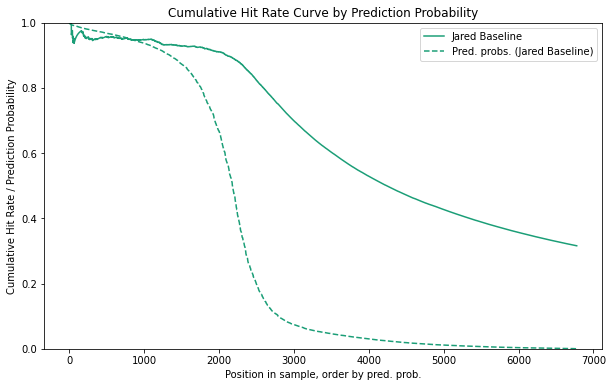

In [11]:
## Plots!
plot_hit_rate_curve(Ytest['dangerous'].astype(int), yhat[:,1], labels=['Jared Baseline'])

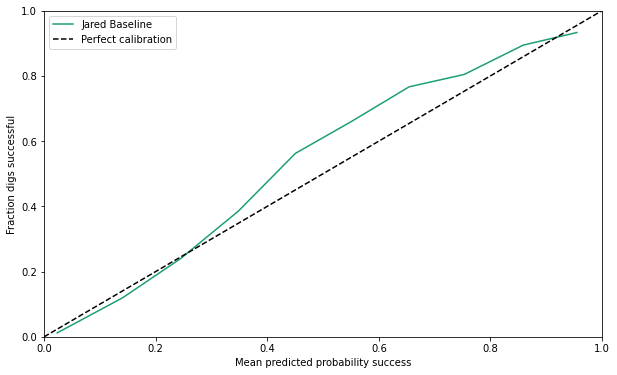

In [12]:
plot_calibration_curve(Ytest['dangerous'].astype(int), yhat[:,1], labels=['Jared Baseline'])

## Multiple models together

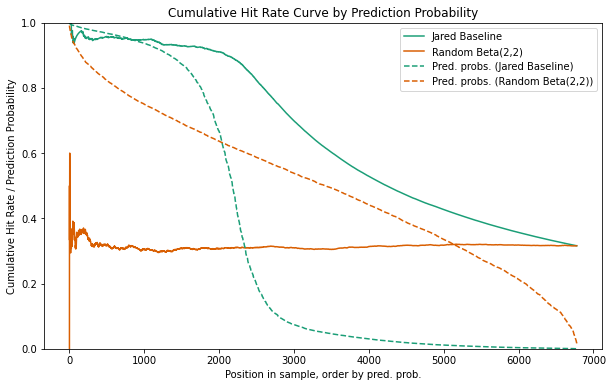

In [13]:
mod_list = [yhat[:,1], 
          np.random.beta(a=2, b=2, size=len(yhat[:,1]))]

plot_hit_rate_curve(Ytest['dangerous'].astype(int), mod_list, labels=['Jared Baseline', 'Random Beta(2,2)'])

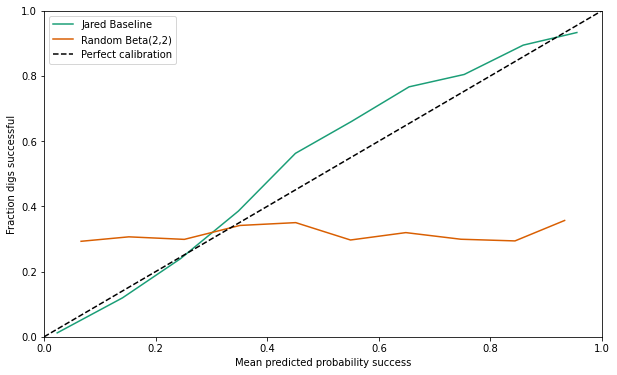

In [14]:
plot_calibration_curve(Ytest['dangerous'].astype(int), mod_list, labels=['Jared Baseline', 'Random Beta(2,2)'])

## Prediction probabilities
The `plot_probs` argument can be set to false to get only the hit rate curve.

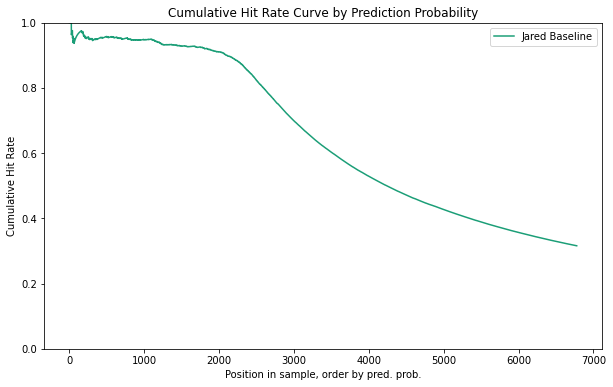

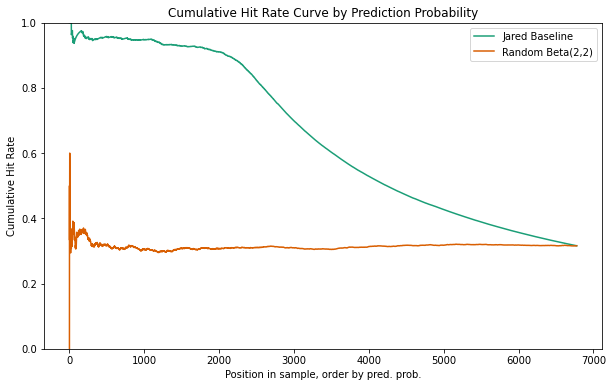

In [15]:
plot_hit_rate_curve(Ytest['dangerous'].astype(int), yhat[:,1], labels=['Jared Baseline'], plot_probs=False)
plot_hit_rate_curve(Ytest['dangerous'].astype(int), mod_list, labels=['Jared Baseline', 'Random Beta(2,2)'], 
                    plot_probs=False)

## Maximum performance
Because there is a set amount of lead in the data, a "perfect" model will still not maintain a hit rate of 100%. For a perfect classifer, the hit rate will be 100% until it reaches the position in the sample where there is no more lead, and will then decrease linearly until reaching the population total. To visualize this, we can set `max_perf = True` in the function call.

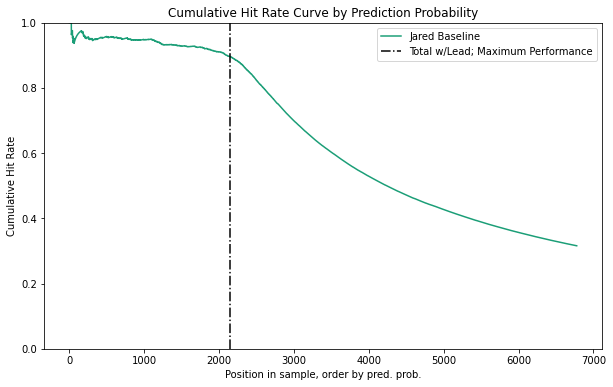

In [16]:
plot_hit_rate_curve(Ytest['dangerous'].astype(int), yhat[:,1], labels=['Jared Baseline'], 
                    plot_probs=False, max_perf=True)

## Ordering by prediction probability
Ordering by the cumulative number in the sample may not represent the different prediction probabilities in a model and its uncertainty. This is particularly true for the baseline models, which typically express greater uncertainty. To "fix" the classification threshold, the `order_by_prob = True` parameter can be passed.


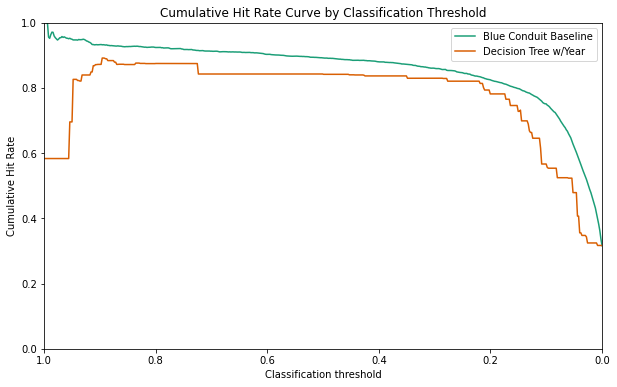

In [17]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(Xtrain['Year Built'].values.reshape(-1,1), Ytrain["dangerous"].values)
dtc_test_preds = dtc.predict_proba(Xtest['Year Built'].values.reshape(-1,1))
mod_list = [yhat[:,1], dtc_test_preds]

plot_hit_rate_curve(Ytest['dangerous'].astype(int), mod_list, labels=['Blue Conduit Baseline', 'Decision Tree w/Year'], 
                    plot_probs=False, order_by_prob=True)

In [25]:
import requests

In [44]:
%%time
latlonglist = ["13.385983,52.496891", "13.385983,52.596893"]

longstr = ''
for i, c in enumerate(latlonglist*10000):
    if i == 0:
        longstr = c
    else:
        longstr += ';' + c

url = f"http://54.158.16.183:5000/table/v1/walking/13.388860,52.517037;{longstr}?sources=0"
r = requests.get(url)
output = r.json()
#output['durations'] # output is in seconds
#output['durations']

CPU times: user 911 ms, sys: 0 ns, total: 911 ms
Wall time: 1.41 s
